In [ ]:
!pip install transformers datasets transformers[torch]

In [ ]:
!unzip yacine.zip

# **Finetuning of Deep Learning Model**

In this section we will provide an the results of training an optimal model to compare its results with the classic feature extraction model.

## **Libraries**

In [2]:
import os

from PIL import Image
import PIL
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import DefaultDataCollator
from transformers import AutoImageProcessor, ResNetModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## **Dataset splitting**

The model will be splitted in train/validation/test splits.
Validation set will only be used to check the evolution of the model performance in a different set than the training split.

In [31]:
data_dir = 'yacine'
train_dir = data_dir + '/train'
val_dir = data_dir + '/validation'

img_height,img_width=50,50
batch_size=32
seed = 123

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  subset="both",
  validation_split=0.2,
  seed=seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

merged_train_val = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2723 files belonging to 2 classes.
Using 2179 files for training.
Using 544 files for validation.
Found 2723 files belonging to 2 classes.
Found 355 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)

['no_pools', 'pools']


## **Model Training**

The model used for training is a ResNet50, popular because of the presence of skip (residual) connections in its architecture. Moreover, the model weights will be loaded from the imagenet dataset.

Then, we will only flatten the 2D output and convert it into a probability distribution using the sigmoid activation function.

In [34]:
def build_model():
    resnet_model = Sequential()

    pretrained_model= tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(img_height,img_width,3),
        pooling='avg',classes=len(class_names),
        weights='imagenet')

    # Freeze layers
    for layer in pretrained_model.layers:
            layer.trainable=False

    # Add trainable layer
    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(1, activation='sigmoid')) # Binary class
    return resnet_model

In [17]:
resnet_model = build_model()
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 1)                 513       
 apper)                                                          
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
________

The model will be trained using **Adam** optimizer with $\alpha = 0.001$ and using the cross-entropy loss.

In [36]:
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
resnet_model = compile_model(resnet_model)

In [19]:
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/5
69/69 [==============================] - 51s 664ms/step - loss: 0.3453 - accuracy: 0.9032 - val_loss: 0.1804 - val_accuracy: 0.9338
Epoch 2/5
69/69 [==============================] - 45s 659ms/step - loss: 0.0849 - accuracy: 0.9642 - val_loss: 0.1927 - val_accuracy: 0.9320
Epoch 3/5
69/69 [==============================] - 44s 631ms/step - loss: 0.0533 - accuracy: 0.9798 - val_loss: 0.1922 - val_accuracy: 0.9449
Epoch 4/5
69/69 [==============================] - 50s 721ms/step - loss: 0.0278 - accuracy: 0.9890 - val_loss: 0.1777 - val_accuracy: 0.9504
Epoch 5/5
69/69 [==============================] - 50s 723ms/step - loss: 0.0107 - accuracy: 0.9982 - val_loss: 0.1836 - val_accuracy: 0.9522


### **Validation**

#### **Accuracy on train and validation set**

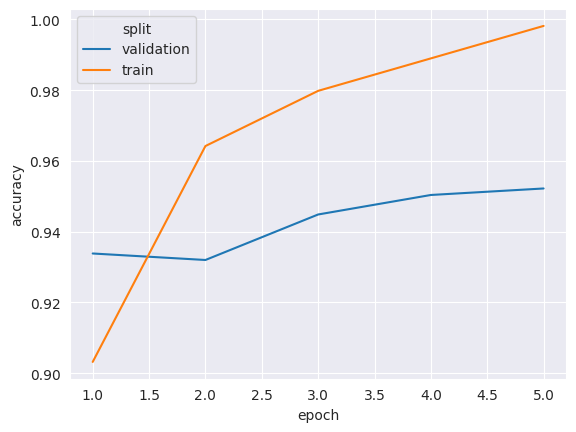

In [22]:
import seaborn as sns

data = {'epoch': [], 'accuracy': [], 'split': []}
for idx, val_acc in enumerate(history.history['val_accuracy']):
  data['split'].append('validation')
  data['accuracy'].append(val_acc)
  data['epoch'].append(idx+1)
for idx, train_acc in enumerate(history.history['accuracy']):
  data['split'].append('train')
  data['accuracy'].append(train_acc)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='accuracy', hue='split');

#### **Loss on train and validation set**

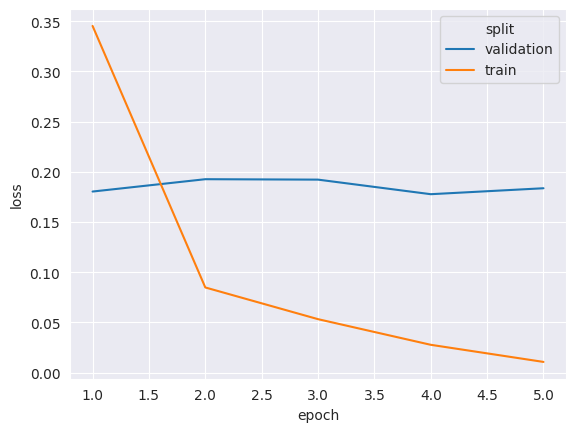

In [23]:
data = {'epoch': [], 'loss': [], 'split': []}
for idx, val_loss in enumerate(history.history['val_loss']):
  data['split'].append('validation')
  data['loss'].append(val_loss)
  data['epoch'].append(idx+1)
for idx, train_loss in enumerate(history.history['loss']):
  data['split'].append('train')
  data['loss'].append(train_loss)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='loss', hue='split');

## **Evaluation**

### **Main Dataset**

Here we train the model again using the full train set (train and validation) to test the model in the test set from each dataset.

In [37]:
epochs=5
resnet_model = build_model()
resnet_model = compile_model(resnet_model)
history = resnet_model.fit(merged_train_val,
                           epochs=epochs)

Epoch 1/5
86/86 [==============================] - 43s 439ms/step - loss: 0.2909 - accuracy: 0.9115
Epoch 2/5
86/86 [==============================] - 38s 440ms/step - loss: 0.0793 - accuracy: 0.9714
Epoch 3/5
86/86 [==============================] - 35s 411ms/step - loss: 0.0440 - accuracy: 0.9831
Epoch 4/5
86/86 [==============================] - 39s 455ms/step - loss: 0.0279 - accuracy: 0.9901
Epoch 5/5
86/86 [==============================] - 37s 433ms/step - loss: 0.0107 - accuracy: 0.9974


In [38]:
pred = resnet_model.predict(test_ds)

12/12 [==============================] - 5s 332ms/step


In [39]:
labels = [int(l) for _, labels in test_ds for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [40]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       166
           1       0.98      0.93      0.95       189

    accuracy                           0.95       355
   macro avg       0.95      0.95      0.95       355
weighted avg       0.95      0.95      0.95       355



In [41]:
cm = confusion_matrix(labels, pred_y)

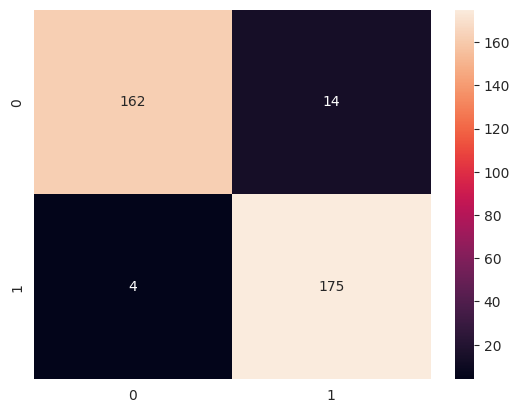

In [42]:
sns.heatmap(cm, annot=True, fmt='');

### **Algarves' Dataset**

In [53]:
%%capture
!unzip formatted_dataset.zip

In [54]:
algarves_formatted_test_dir = 'formatted_dataset'

algarves_ds_formatted = tf.keras.preprocessing.image_dataset_from_directory(
  algarves_formatted_test_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 289 files belonging to 2 classes.


In [55]:
pred = resnet_model.predict(algarves_ds_formatted)

10/10 [==============================] - 7s 694ms/step


In [56]:
labels = [int(l) for _, labels in algarves_ds_formatted for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [57]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.91      0.88      0.89       179

    accuracy                           0.87       289
   macro avg       0.86      0.87      0.87       289
weighted avg       0.87      0.87      0.87       289



In [58]:
cm = confusion_matrix(labels, pred_y)

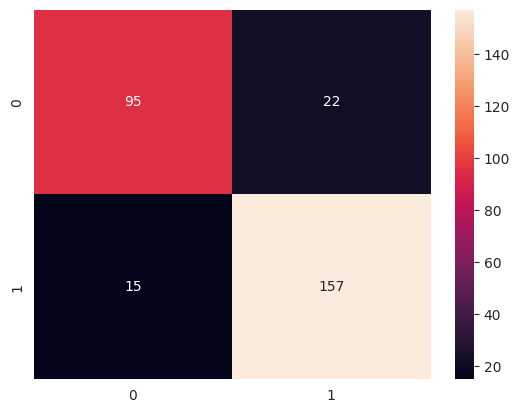

In [59]:
sns.heatmap(cm, annot=True, fmt='');

### **Fragmented Algarves' Dataset**

In [46]:
%%capture
!unzip fragmented_dataset.zip

In [47]:
algarves_test_dir = 'fragmented_dataset'

algarves_ds = tf.keras.preprocessing.image_dataset_from_directory(
  algarves_test_dir,
  seed=seed,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2199 files belonging to 2 classes.


In [48]:
pred = resnet_model.predict(algarves_ds)

69/69 [==============================] - 36s 524ms/step


In [49]:
labels = [int(l) for _, labels in algarves_ds for l in labels]
pred_y = [x[0] for x in pred]
pred_y = np.round(pred_y).astype(int)

In [50]:
cr = classification_report(pred_y, labels)
print(cr)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1349
           1       0.98      0.40      0.57       850

    accuracy                           0.77      2199
   macro avg       0.85      0.70      0.71      2199
weighted avg       0.82      0.77      0.74      2199



In [51]:
cm = confusion_matrix(labels, pred_y)

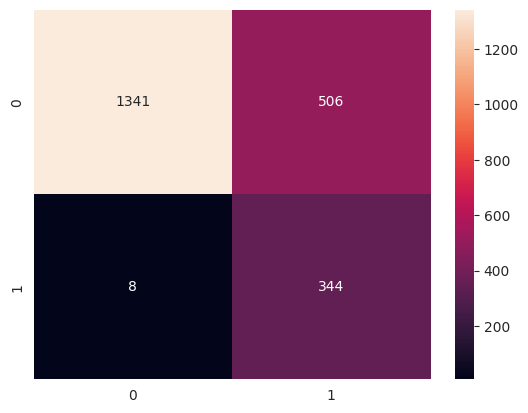

In [52]:
sns.heatmap(cm, annot=True, fmt='');